# Bayesian Hyperparameter Inference for Gaussian Process Regression with US Census Data

In this experiment, we perform Bayesian inference on the hyperparameters of a Gaussian process regression model for a subset of some recent US census data, which can be retrieved from [Kaggle](https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data?resource=download&select=acs2015_county_data.csv), normalized so that both the features and the target variable have sample mean zero and sample variance one. Our inspiration for this is an experiment on the same type problem but for different data that was described by [Nishihara et al. (2014)](https://www.jmlr.org/papers/volume15/nishihara14a/nishihara14a.pdf)

The target distribution is constructed as follows. Denote the given data as $(a,b) = (a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}}$, where $a^{(i)} \in \mathbb{R}^d$ and $b^{(i)} \in \mathbb{R}$. Suppose we want to model the data by *Gaussian process* (GP) *regression*. That is, we model it by a posterior distribution over an infinite-dimensional space of latent functions $f: \mathbb{R}^d \rightarrow \mathbb{R}$. The likelihood is obtained from

$$
b^{(i)} = f(a^{(i)}) + \varepsilon_i ,
\qquad \varepsilon_i \sim \mathcal{N}(0,\sigma^2) ,
$$

with the noise variables $\varepsilon_i$ being independent and $\sigma^2 \geq 0$ a fixed hyperparameter (we use $\sigma^2 = 10^{-2}$).
The prior is a GP prior with mean zero and covariance determined by an *anisotropic radial basis function* (RBF) *kernel*, i.e. a function $k^{(\gamma)}: \mathbb{R}^d \rightarrow \mathbb{R}^d$ of the form

$$
k^{(\gamma)}(a, a^{\prime}) 
= \exp\left( -\frac{1}{2} \sum_{j=1}^d \frac{(a_j - a^{\prime}_j)^2}{\gamma_j^2} \right) ,
\qquad a, a^{\prime} \in \mathbb{R}^d ,
$$

which has $d$ length scale parameters $\gamma = (\gamma_1,...,\gamma_d) \in \; ]0,\infty[^d$ that are a priori hyperparameters to the GP regression model.

To obtain a good model, we want to infer these length scale hyperparameters through the Bayesian framework, which is commonly done by placing a suitable prior on them and using the marginal likelihood of the data in the above GP model as the likelihood for a given $\gamma$ (see [Rasmussen & Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf), Chapter 5). Recall that the *kernel matrix* for the data $(a,b)$ corresponding to the kernel $k^{(\gamma)}$ is the matrix $K^{(\gamma)} \in \mathbb{R}^{n_{\text{data}} \times n_{\text{data}}}$ with entries

$$
K^{(\gamma)}_{i,i^{\prime}} = k^{(\gamma)}(a^{(i)}, a^{(i^{\prime})}) ,
\qquad i,i^{\prime} \in \{1,...,n_{\text{data}}\} ,
$$

and note that it can be used to concisely write the marginal likelihood of the data for a given kernel $k^{(\gamma)}$ as

$$
p(b \mid a, \gamma)
= \mathcal{N}_{n_{\text{data}}}(b; 0, K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})
\propto \det(K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})^{-1/2} \exp\left( -\frac{1}{2} b^T (K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})^{-1} b \right) ,
\qquad \gamma \in \; ]0,\infty[^d ,
$$

see [Rasmussen & Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf), equation 5.8. Following [Nishihara et al. (2014)](https://www.jmlr.org/papers/volume15/nishihara14a/nishihara14a.pdf), we use the independent exponential prior

$$
p(\gamma) 
= \prod_{j=1}^d \text{Exp}(\gamma_j; r)
\propto \exp\left( -r \sum_{j=1}^d \gamma_j \right)
$$

with fixed rate $r = 0.1$. 

As preliminary experimentation showed this to enormously improve mixing, we symmetrize the target. That is, we extend its support to all vectors $\gamma \in \mathbb{R}^d$ with no non-zero entries (instead of just those with only positive entries) by replacing the positively constrained $\gamma$ in the above formulas for prior and likelihood by the entry-wise absolute value $\vert \gamma \vert$ of the new unconstrained $\gamma$. As we do not require the target density to be normalized, we may set it to the product of prior and likelihood, so that we obtain the target density

$$
\varrho(\gamma) 
= \exp\left( -r \sum_{j=1}^d \vert \gamma_j \vert \right) \det(K^{(\vert \gamma \vert)} + \sigma^2 I_{n_{\text{data}}})^{-1/2} \exp\left( -\frac{1}{2} b^T (K^{(\vert \gamma \vert)} + \sigma^2 I_{n_{\text{data}}})^{-1} b \right) ,
\qquad \gamma \in \mathbb{R}^d, \gamma_j \neq 0 \, \forall j ,
$$

which corresponds to the log target density

$$
\log \varrho(\gamma) 
= -r \sum_{j=1}^d \vert \gamma_j \vert - \frac{1}{2} \log(\det(K^{(\vert \gamma \vert)} + \sigma^2 I_{n_{\text{data}}})) - \frac{1}{2} b^T (K^{(\vert \gamma \vert)} + \sigma^2 I_{n_{\text{data}}})^{-1} b ,
\qquad \gamma \in \mathbb{R}^d, \gamma_j \neq 0 \, \forall j .
$$

Note that, unfortunately, the Bayesian approach employed here to infer the parameters $\gamma$ is computationally infeasible for all but the smallest data sets because every evaluation of the above target density involves computing the kernel matrix $K^{(\gamma)}$, which has complexity $\mathcal{O}(n_{\text{data}}^2 d)$, as well as the inverse and determinant of $K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}}$, each of which has complexity $\mathcal{O}(n_{\text{data}}^3)$.

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/Bayesian_hyperparam_inf_GP_regression_"

### Construct Target Density
#### Retrieve and Preprocess the Data

In [4]:
# load data set from file
data = pd.read_csv("../data/acs2015_county_data.csv")
data

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


In [5]:
# create copy of the data with all unwanted columns and the target variable removed
removed_cols = [
    'CensusId', # unique id of each data point
    'State', # categorical
    'County', # another unique identifier of each data point
    'Income', # median household income; the target variable for regression
    'IncomeErr', # too closely linked to the target variable
    'IncomePerCap', # too closely linked to the target variable
    'IncomePerCapErr', # too closely linked to the target variable
]
filtered_data = data.drop(columns = removed_cols)
filtered_data

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,56858,27379,29479,96.4,3.4,0.1,0.0,0.0,0.0,43656,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,9130,4585,4545,96.7,2.9,0.0,0.0,0.0,0.0,7085,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,24685,12086,12599,99.7,0.0,0.0,0.0,0.0,0.0,18458,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,36279,17648,18631,99.8,0.2,0.0,0.0,0.1,0.0,27924,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


In [6]:
# extract/set the experiment's parameters regarding the target distribution
n_data = 100 # controls how many of the given data points are used
d = filtered_data.shape[1] # dimension of the problem
sig_sq = 0.01 # noise variance parameter sigma^2
prior_rate = 0.1 # rate parameter of the exponential distribution used within the prior on \gamma

In [7]:
# randomly select n_data pairwise distinct data points 
inds = rnd.choice(a = filtered_data.shape[0], size = n_data, replace = False)
feats = filtered_data.to_numpy()[inds]
tar_var = data['Income'].to_numpy()[inds]

In [8]:
# to improve reproducibility, print which data points were chosen 
np.sort(inds)

array([  52,  101,  106,  111,  123,  240,  259,  329,  373,  387,  401,
        497,  505,  515,  561,  587,  617,  648,  651,  664,  679,  681,
        717,  747,  801,  815,  879,  945,  998, 1001, 1009, 1045, 1046,
       1060, 1101, 1195, 1223, 1263, 1441, 1469, 1485, 1503, 1517, 1522,
       1599, 1625, 1638, 1696, 1698, 1705, 1716, 1750, 1891, 1899, 1954,
       1957, 1997, 2021, 2030, 2098, 2123, 2125, 2151, 2163, 2182, 2231,
       2311, 2374, 2378, 2406, 2427, 2442, 2454, 2470, 2494, 2552, 2595,
       2605, 2650, 2658, 2663, 2696, 2699, 2729, 2748, 2759, 2774, 2777,
       2808, 2845, 2970, 2984, 3004, 3039, 3064, 3066, 3067, 3082, 3085,
       3086])

In [9]:
# normalize the features and target variable
a = (feats - np.mean(feats, axis=0)) / np.std(feats, axis=0)
b = (tar_var - np.mean(tar_var, axis=0)) / np.std(tar_var)

In [10]:
# do precalc for more efficient target evaluation
a_squares = ( a.reshape(n_data,1,d) - a.reshape(1,n_data,d) )**2

In [11]:
def log_density(gamma):
    if np.any(gamma == 0.0):
        return -np.inf
    K = np.exp(- np.inner(a_squares, 1/np.abs(gamma)) / 2) + sig_sq * np.identity(n_data)
    log_det_K = alg.slogdet(K)[1]
    K_inv = alg.inv(K)
    return - prior_rate * np.sum(np.abs(gamma)) - log_det_K / 2 - np.inner(b, K_inv @ b) / 2

### Run the Samplers
In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

**Note:** If either PATT-GPSS or GESS is run before HRUSS and AdaRWM, it breaks the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [12]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(2e4) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = rnd.normal(scale=10, size=(n_chains,d)) # suggested initial states

#### Hit-and-run Uniform Slice Sampling

In [13]:
w_hruss = np.sqrt(d)

In [14]:
samples_hruss, tde_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:21<00:00, 76.35it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis

**Note:** We let AdaRWM run for a far larger total number of iterations than the other samplers because it takes extremely long to even reach the target distribution's mode. This is somewhat justified by AdaRWM needing only a single TDE per iteration, so that the overall runtime stays moderate.

In [15]:
rwm_it_scale = 10
n_its_rwm = rwm_it_scale * n_its

In [16]:
samples_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|███████████████████████████████████████████████████████████████████████████████| 200000/200000 [06:56<00:00, 479.69it/s]


Processing returns and terminating...


In [17]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

#### PATT Elliptical Slice Sampling

In [18]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [19]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cov_mode='var',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [20]:
samples_ess = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_ess = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_ess = ret_dic['means']
stds_ess = ret_dic['std_devs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [21]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = d
w_att = np.sqrt(d)

In [22]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cov_mode='var',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [23]:
samples_gpss = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_gpss = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_gpss = ret_dic['means']
stds_gpss = ret_dic['std_devs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling

**Note:** We grant GESS significantly more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.


In [24]:
n_chains_gess = max(2*d, n_chains)
x_0s_gess = rnd.normal(scale=10, size=(2*n_chains_gess,d))

In [25]:
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its, x_0s_gess)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/40002 [00:00<?, ?it/s]

Assembling output...


In [26]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

### Analyze Sampling Performance
#### Performance Metrics
As the quantities of interest in this case are not the samples themselves but rather their entry-wise absolute values, we compute the performance metrics based on the latter.

In [27]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS"]
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess]
n_burns = np.array([n_its, n_its, n_its, n_its_rwm, n_its], dtype=int) // 2
nsam = len(snames)

In [28]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
abs_samples = [np.abs(sams) for sams in samples]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(abs_samples)

In [29]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
maxls = [2500, 2500, 5000, 5000, 5000]
mean_iats = mcu.mean_iat_multi_chain_list(abs_samples, maxls)
msss = mcu.mss_list(abs_samples)

In [30]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(mean_tde * mean_iats, 2), # TDE per effective sample = total TDE / total ES = TDE/it / ES/it = TDE/it / IAT
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "mean IAT",
        "MSS",
        "TDE/ES",
        "TDE/MSS",
    ]
)


,Sampler,Burn-In TDE/it,TDE/it,mean IAT,MSS,TDE/ES,TDE/MSS
0,PATT-ESS,6.75,6.06,45.62,13.16,276.52,0.46
1,PATT-GPSS,11.43,11.26,37.71,21.66,424.69,0.52
2,HRUSS,6.68,6.71,244.62,6.13,1641.75,1.09
3,AdaRWM,1.0,1.0,503.26,1.21,503.26,0.83
4,GESS,7.14,7.14,184.59,8.05,1318.77,0.89


#### Convergence of Estimates of a Target Quantity

In [31]:
# compute all estimates of the target quantity, while only considering as many chains of GESS as of the other samplers
mean_norms = nsam * [None]

for i in range(nsam):
    n_it = abs_samples[i].shape[0]
    cum_sums = np.cumsum(np.sum(abs_samples[i][:,:n_chains], axis=1), axis=0) 
    means = cum_sums / (n_chains * np.arange(1, n_it+1)).reshape(-1,1)
    mean_norms[i] = alg.norm(means, axis=1)

In [32]:
# compute cumulative TDE counts
cum_tdes = [np.cumsum(np.sum(tde_[:,:n_chains], axis=1)) for tde_ in tde]

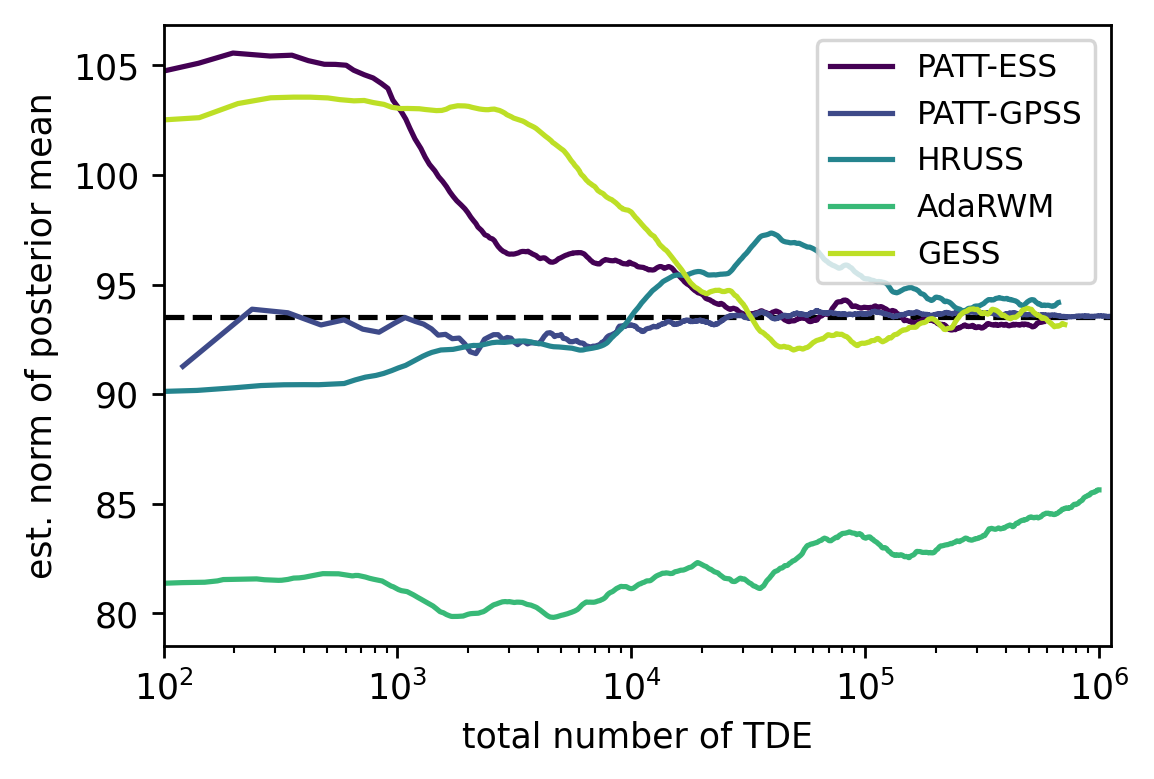

In [53]:
# plot their progression over the iterations
path = path_prefix + "conv.png"
figsize = (4.5,3)
dpi = 250
colors = plt.cm.viridis(np.linspace(0,0.9,nsam))
max_cum_tde = np.max([cum_tde[-1] for cum_tde in cum_tdes]) # for reference line and xlim
ref_norm = mean_norms[1][-1] # reference norm := final estimate by PATT-GPSS
pfs.initiate(figsize, dpi)
for i in range(nsam):
    plt.plot(cum_tdes[i], mean_norms[i], color=colors[i])
plt.legend(snames, loc='upper right', fontsize=9)
plt.plot([n_chains, max_cum_tde], np.full(2, ref_norm), color='k', linestyle='dashed', zorder=-2)
plt.xscale('log')
plt.xlim(1e2, max_cum_tde)
plt.xlabel("total number of TDE")
plt.ylabel("est. norm of posterior mean")
pfs.wrapup(path)

### Additional Plotting

In [34]:
n_win = int(1e4)

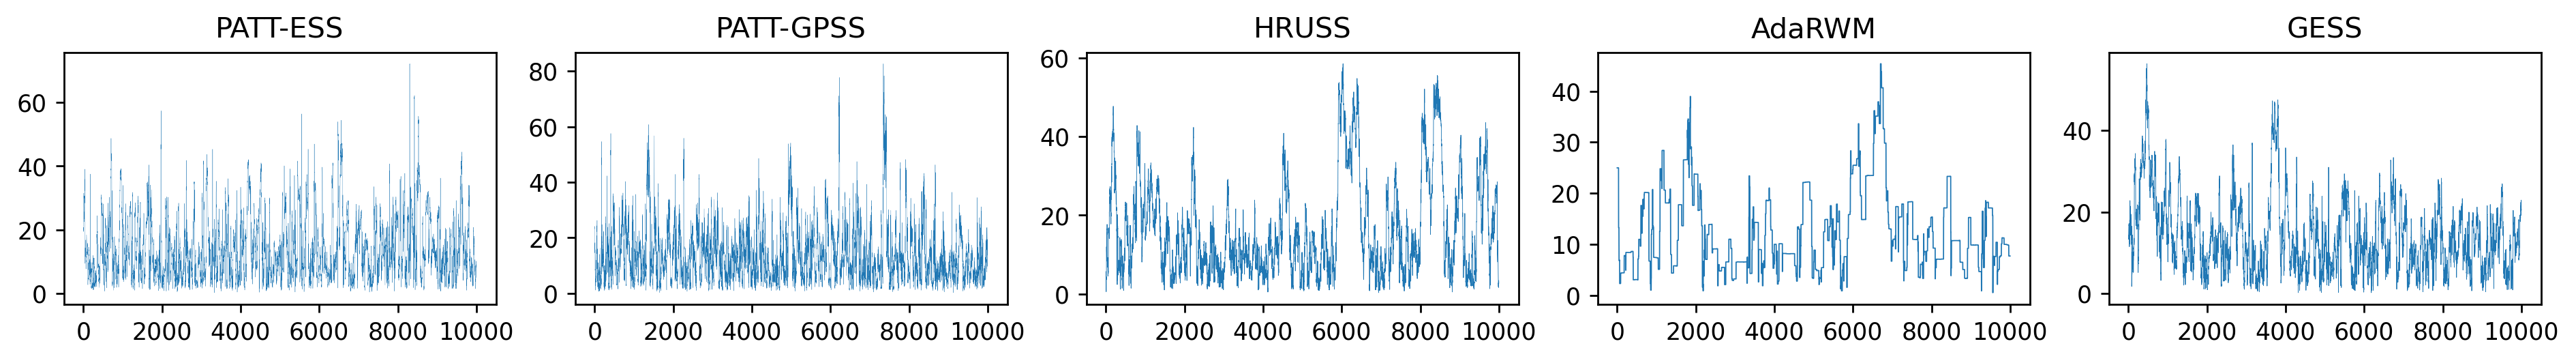

In [35]:
lws = [0.1, 0.1, 0.25, 0.5, 0.25]
path = path_prefix + "abs_marginal_trace.png"
pfs.trace_plot_row([asams[-n_win:,0,0] for asams in abs_samples], snames, dpi=dpi, filepath=path, lws=lws)

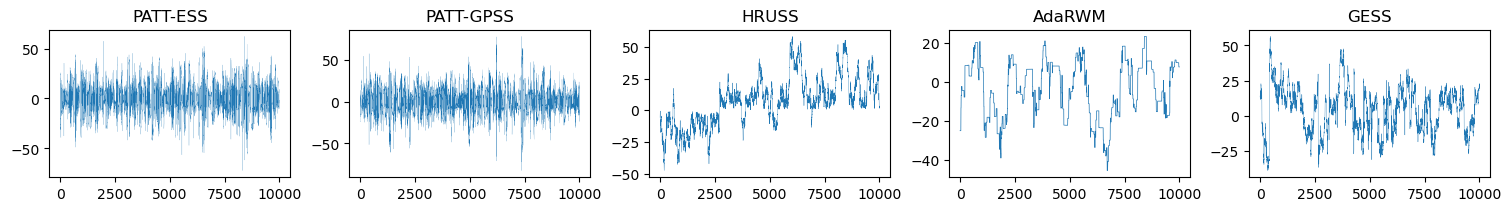

In [36]:
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

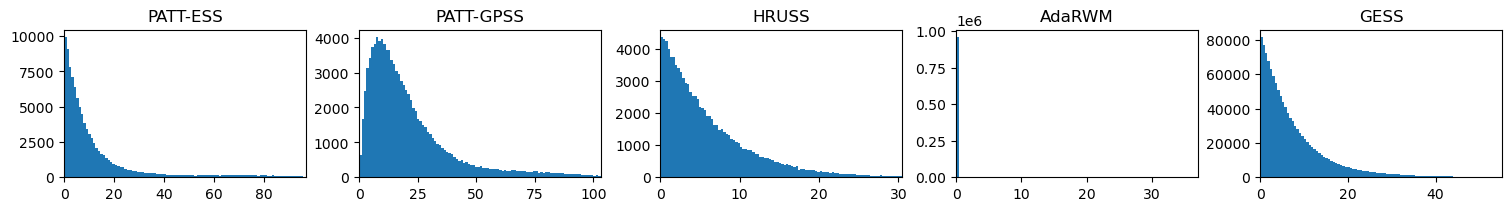

In [37]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[2] = plot_steps[2][plot_steps[2] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

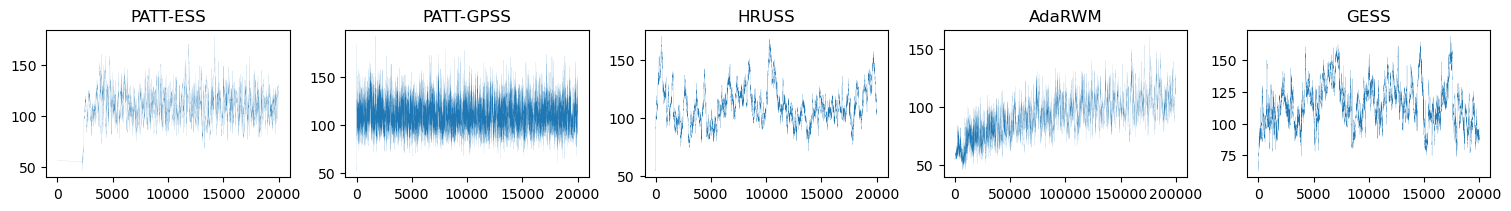

In [38]:
lws = [0.05, 0.05, 0.1, 0.05, 0.1]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

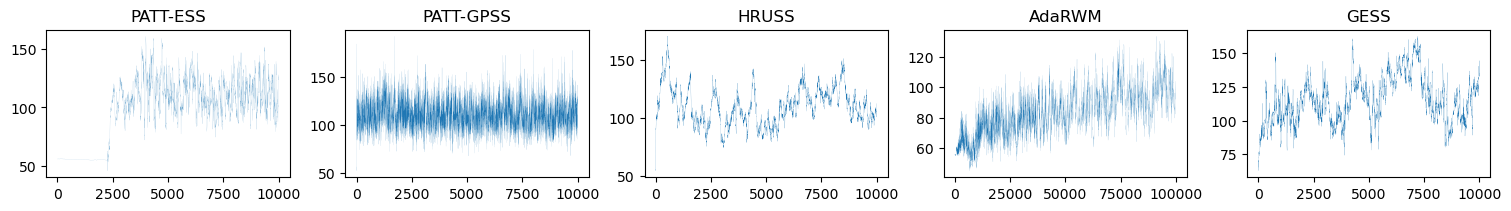

In [39]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

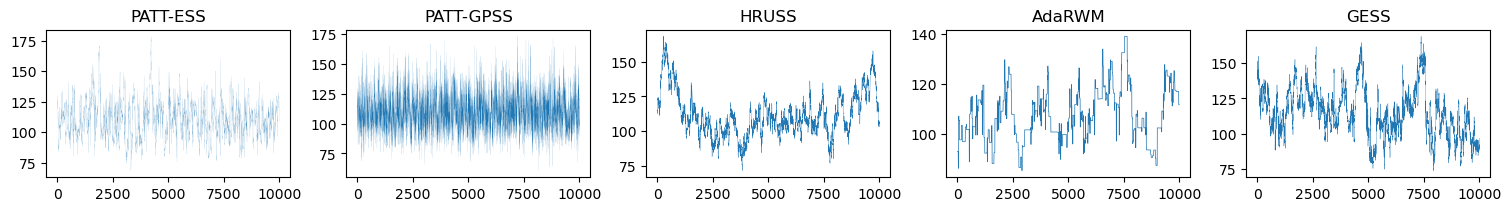

In [40]:
lws = [0.05, 0.05, 0.25, 0.5, 0.25]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

**Note:** The above radius plot should give a particularly good glimpse into the frequency with which the different samplers ventured far into the tails, and correspondingly how much effort it took them to embark on and eventually return from these trips.

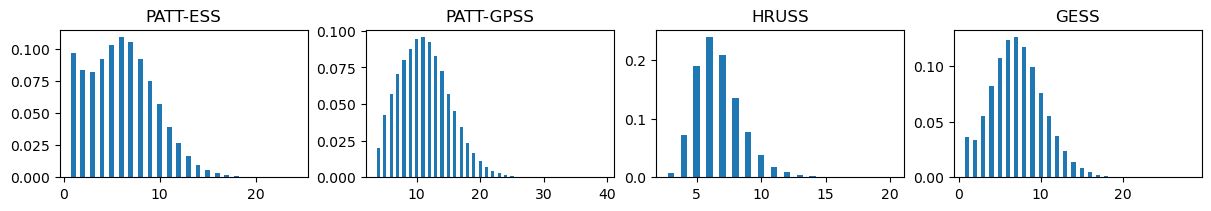

In [41]:
no_rwm = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in no_rwm], [snames[i] for i in no_rwm])

In [42]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.088
Minimal AdaRWM acceptance rate: 0.084
Maximal AdaRWM acceptance rate: 0.095


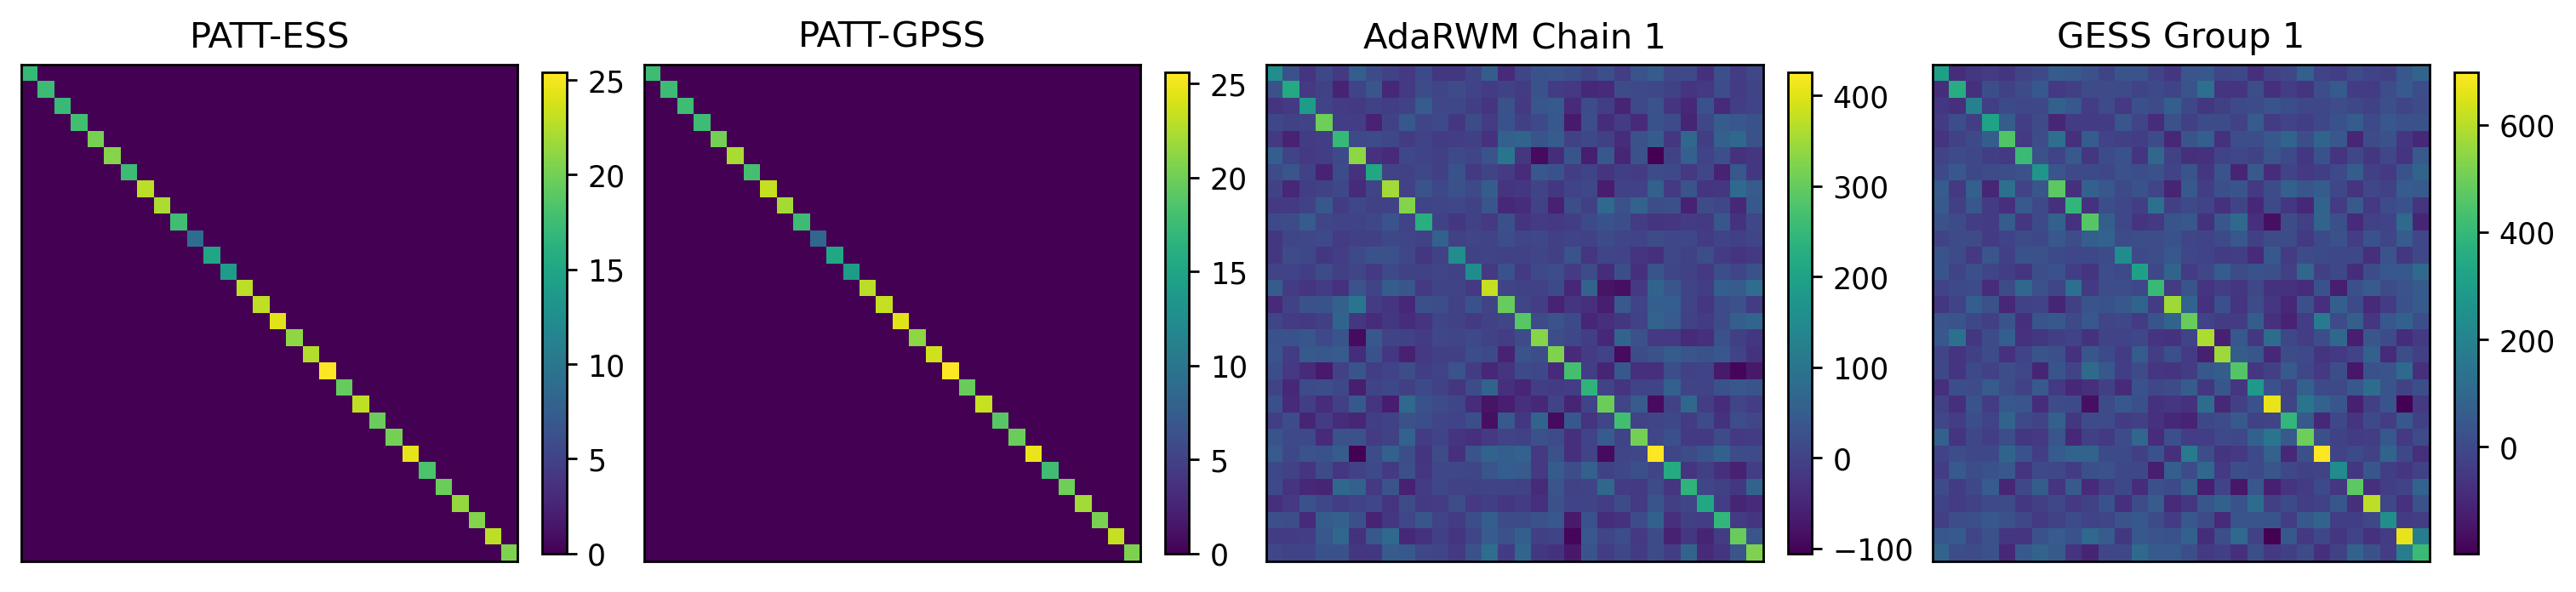

In [43]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [np.diag(stds_ess[-1]), np.diag(stds_gpss[-1]), cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.775)

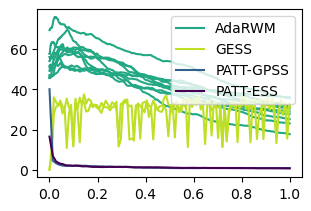

In [44]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_rwm = mcu.get_radii(means_rwm)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess / schedule_gess[-1], norms_gess[:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

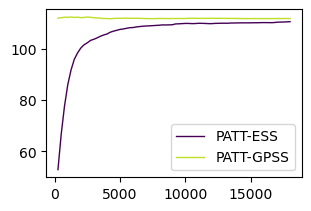

In [45]:
# plot progressions of the norm of the PATT samplers' posterior coordinate variance approximations
std_norms_ess = mcu.get_radii(stds_ess)
std_norms_gpss = mcu.get_radii(stds_gpss)
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], std_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], std_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

In [46]:
if dfs_G1[dfs_G1 != 1e6].shape[0] + dfs_G2[dfs_G2 != 1e6].shape[0] > 2:
    plt.figure(figsize=(6,2))
    for dfs in [dfs_G1, dfs_G2]:
        plt.plot(schedule_gess[1:], dfs[1:], marker='.')
    plt.legend(["dfs Group {}".format(i+1) for i in range(2)])
    plt.ylim((0,2*np.max(np.concatenate([dfs_G1[dfs_G1 != 1e6], dfs_G2[dfs_G2 != 1e6]]))))
    plt.show()

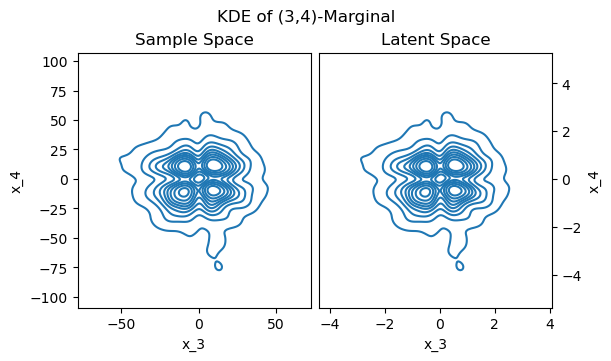

In [47]:
# plot a bivariate marginal KDE in sample space and (PATT-GPSS's final) latent space
inds = [3,4]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[1][:,0,inds[0]].reshape(-1,1),
                                samples[1][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
alpha_inv = lambda y: y / stds_gpss[-1]
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[1][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

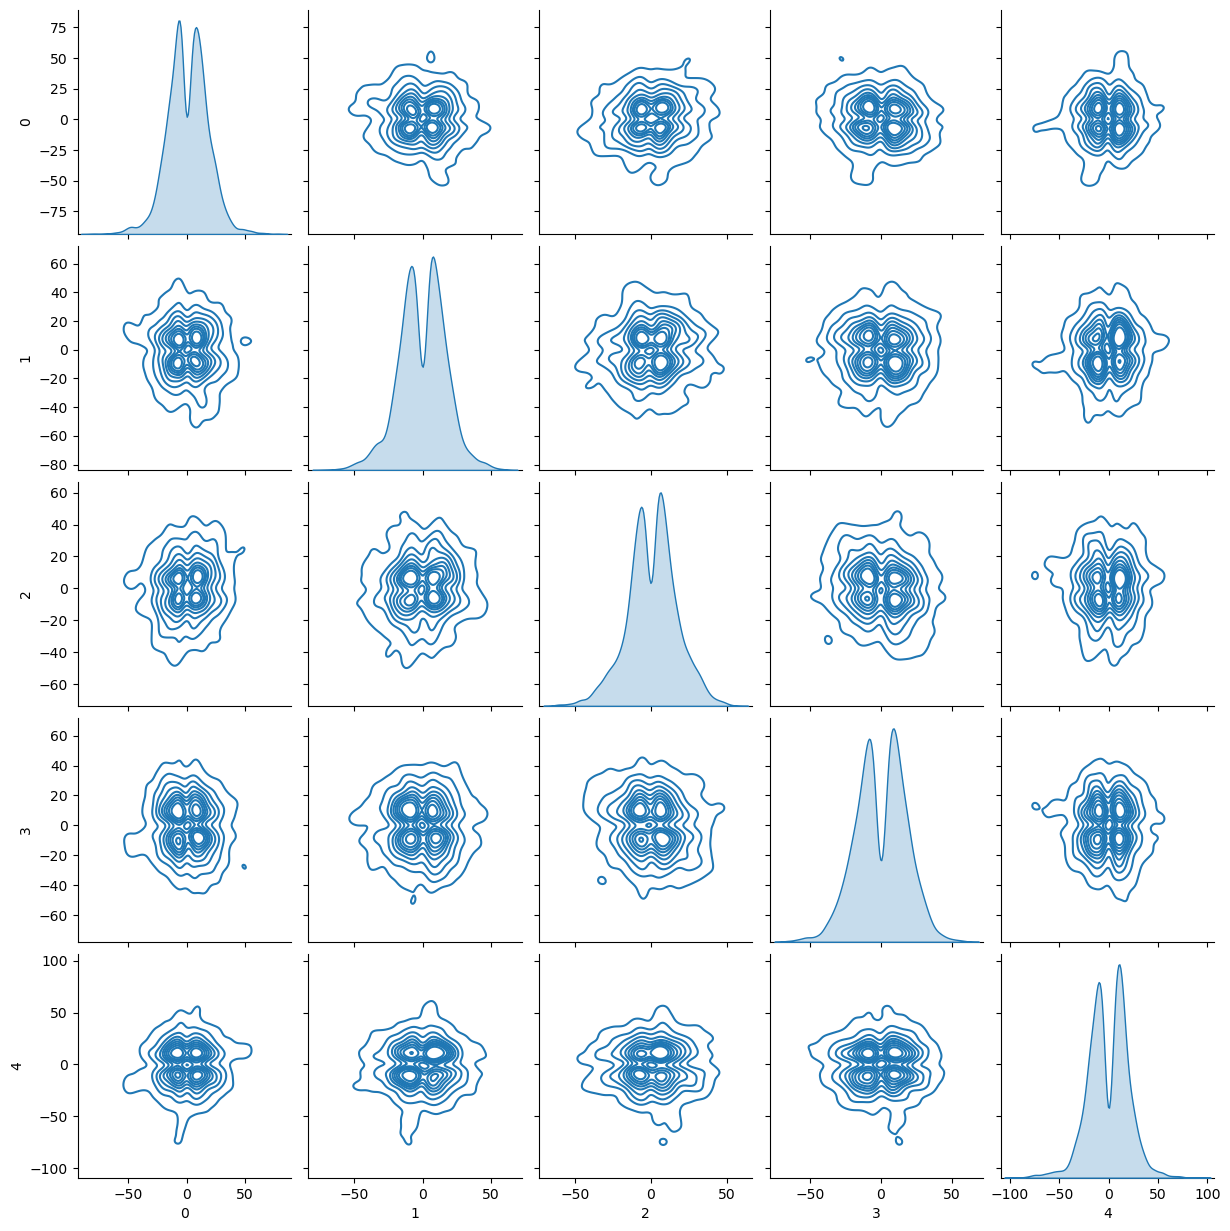

In [48]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples_gpss[-n_win:,0,:5]), kind='kde')
plt.show()

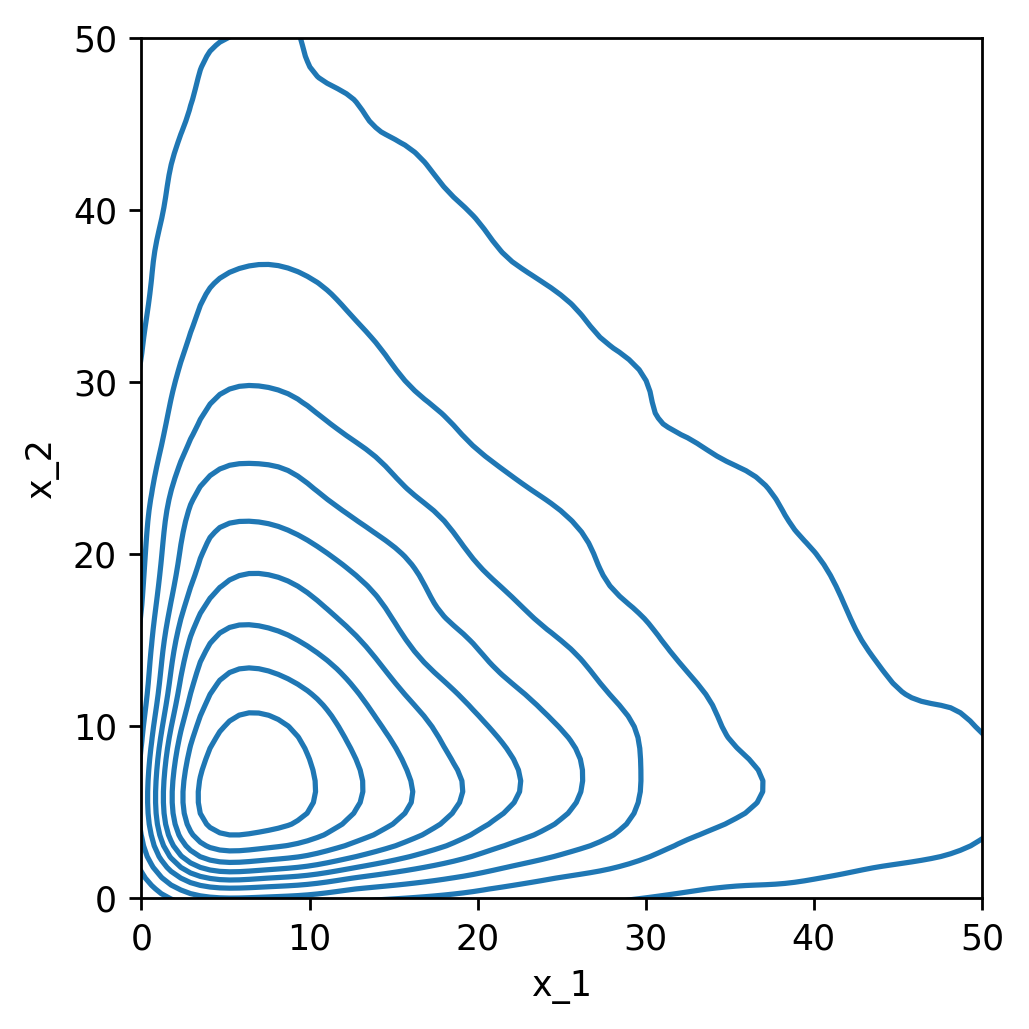

In [49]:
# generate illustration of non-symmetrized target for the paper
path = path_prefix + "bivariate_abs_marginal.png"
figsize = (4,4)
pfs.initiate(figsize, dpi)
ax_labels = ["x_1", "x_2"]
frame = pd.DataFrame(abs_samples[1].reshape(-1,d)[:,:2], columns=ax_labels)
sb.kdeplot(frame, x=ax_labels[0], y=ax_labels[1])
plt.xlim(0,50)
plt.ylim(0,50)
pfs.wrapup(path)

The above plot shows the non-symmetrized version of the target to have level sets that are almost triangular and thus far from elliptical. For the symmetrized target, the level sets at high thresholds consist of many such triangles, which at lower thresholds eventually merge into one large that is still more angular than round.